# **Import Libraries**

In [2]:
# change dir
import sys
from pathlib import Path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# import needed libraries
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from sklearn.model_selection import RandomizedSearchCV
from src.utils import *
import matplotlib.pyplot as plt
import json

# **Deserialize Data**

In [14]:
# oversampling
X_train_ros = deserialize_data(path=project_root/'data'/'processed'/'X_train_ros.pkl')
y_train_ros = deserialize_data(path=project_root/'data'/'processed'/'y_train_ros.pkl')

# valid
X_valid = deserialize_data(path=project_root/'data'/'processed'/'X_valid_prep.pkl')
y_valid = deserialize_data(path=project_root/'data'/'interim'/'y_valid.pkl')

# test
X_test = deserialize_data(path=project_root/'data'/'processed'/'X_test_prep.pkl')
y_test = deserialize_data(path=project_root/'data'/'interim'/'y_test.pkl')

Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/processed/X_train_ros.pkl has been successfully loaded!.
Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/processed/y_train_ros.pkl has been successfully loaded!.
Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/processed/X_valid_prep.pkl has been successfully loaded!.
Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/interim/y_valid.pkl has been successfully loaded!.
Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/processed/X_test_prep.pkl has been successfully loaded!.
Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/data/interim/y_test.pkl has been successfully loaded!.


# **Train Models**

In [30]:
# set hyperparameter spaces for each model

# decision tree 
dt_params = {
    'max_depth': list(np.arange(1, 15)),
    'min_samples_split': [2, 5]
}

# random forest
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

# xgboost
xgb_params = {
    'n_estimators': [100, 200, 500, 750, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'reg_lambda': [0, 0.1, 0.25, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 0.5]
    }

In [31]:
# define each model's instance
dtc = DTC()
xgb = XGB(n_jobs=-1)
rf = RFC(n_jobs=-1)

In [32]:
# define train models function
def train_model(estimator: Any,
    params: Dict[str, list],
    X_train: np.ndarray,
    y_train: np.ndarray
) -> RandomizedSearchCV:
    """
    Train a classification model using hyperparameter tuning with RandomizedSearchCV.

    This function performs randomized hyperparameter search on the given estimator
    using the provided parameter distributions. The training is conducted only
    on the training dataset to avoid data leakage.

    Parameters
    ----------
    estimator : Any
        A machine learning model instance (e.g., DecisionTreeClassifier,
        RandomForestClassifier, XGBClassifier).

    params : Dict[str, list]
        Dictionary containing hyperparameter search space.
        Keys are hyperparameter names, and values are lists of candidate values.

    X_train : np.ndarray
        Training feature matrix.

    y_train : np.ndarray
        Training target vector (labels).

    Returns
    -------
    RandomizedSearchCV
        A fitted RandomizedSearchCV object containing:
        - best_estimator_
        - best_params_
        - best_score_
        - cv_results_
    """
    
    # create tuner object
    model = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=params,
        n_iter=50,
        scoring='f1',
        n_jobs=-1,
        verbose=3
    )

    # fit tuner
    model.fit(X_train, y_train)

    return model

In [33]:
# train all models
dt_model = train_model(estimator=dtc, params=dt_params, X_train=X_train_ros, y_train=y_train_ros)
dt_best_model = dt_model.best_estimator_

rf_model = train_model(estimator=rf, params=rf_params, X_train=X_train_ros, y_train=y_train_ros)
rf_best_model = rf_model.best_estimator_

xgb_model = train_model(estimator=xgb, params=xgb_params, X_train=X_train_ros, y_train=y_train_ros)
xgb_best_model = xgb_model.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/BAGAS_VENV.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 5/5] END ..max_depth=1, min_samples_split=2;, score=0.536 total time=   0.1s[CV 1/5] END ..max_depth=1, min_samples_split=2;, score=0.533 total time=   0.1s
[CV 3/5] END ..max_depth=1, min_samples_split=2;, score=0.530 total time=   0.1s
[CV 2/5] END ..max_depth=1, min_samples_split=5;, score=0.535 total time=   0.1s

[CV 4/5] END ..max_depth=1, min_samples_split=5;, score=0.522 total time=   0.1s
[CV 5/5] END ..max_depth=1, min_samples_split=5;, score=0.536 total time=   0.1s
[CV 1/5] END ..max_depth=2, min_samples_split=2;, score=0.755 total time=   0.1s
[CV 2/5] END ..max_depth=1, min_samples_split=2;, score=0.535 total time=   0.1s
[CV 2/5] END ..max_depth=2, min_samples_split=2;, score=0.751 total time=   0.1s
[CV 3/5] END ..max_depth=2, min_samples_split=2;, score=0.757 total time=   0.1s
[CV 4/5] END ..max_depth=2, min_samples_split=2;, score=0.745 total time=   0.1s
[CV 4/5] END ..max_depth=1, min_samples_split=2;, score=0.522 total time=   0.1s
[CV 5/5] END ..max_depth=2, 

/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/BAGAS_VENV.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.964 total time=   8.7s
[CV 2/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.966 total time=   7.2s
[CV 3/5] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.979 total time=   5.3s
[CV 1/5] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.938 total time=  24.4s
[CV 2/5] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.941 total time=  24.3s
[CV 4/5] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.946 total time=  23.6s
[CV 3/5] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=0.952 total time=  25.5s
[CV 5/5] END max_depth=50, max_

# **Serialize Trained Models**

In [34]:
# save trained models to models folder
serialize_data(data=dt_best_model, path=project_root/'models'/'dt_model.pkl')
serialize_data(data=rf_best_model, path=project_root/'models'/'rf_model.pkl')
serialize_data(data=xgb_best_model, path=project_root/'models'/'xgb_model.pkl')


Saving object. . .
Your object has been successfully saved and stored into: /home/bagaskoroah/ml_process/BAGAS_MLPROCESS/models/dt_model.pkl

Saving object. . .
Your object has been successfully saved and stored into: /home/bagaskoroah/ml_process/BAGAS_MLPROCESS/models/rf_model.pkl

Saving object. . .
Your object has been successfully saved and stored into: /home/bagaskoroah/ml_process/BAGAS_MLPROCESS/models/xgb_model.pkl



# **Threshold Tuning**

In [133]:
def threshold_tuning(estimator: Any, X_valid: pd.DataFrame, y_valid: pd.Series)-> List:
    """
    Perform threshold tuning on a trained classification model.

    Parameters
    ----------
    estimator : Any
        Trained classification model supporting predict_proba().

    X_valid : pd.DataFrame
        Validation feature dataset.

    y_valid : pd.Series
        Validation target labels.

    Returns
    -------
    Dict[str, List]
        Dictionary containing:
        - model_name: name of the estimator
        - threshold: threshold values tested
        - metric_score: metric value at each threshold
            
    """
    # copy valid data so remain immutable
    X_valid = X_valid.copy()
    y_valid = y_valid.copy()

    # define threshold point
    thresh_list = np.linspace(0.01, 1, 100)

    # store each threshold performance to list of dict
    results = list()

    # define y prob
    y_prob = estimator.predict_proba(X_valid)[:, 1]

    # iterate every performance on each threshold point
    for t in thresh_list:
        y_pred_prob = (y_prob >= t).astype(int)
        recall_score = classification_report(y_valid, y_pred_prob, output_dict=True)['1']['recall']
        precision_score = classification_report(y_valid, y_pred_prob, output_dict=True)['1']['precision']
        f1_score = classification_report(y_valid, y_pred_prob, output_dict=True)['1']['f1-score']

        results.append({
            'model': estimator.__class__.__name__,
            'threshold': float(t),
            'recall': recall_score,
            'precision': precision_score,
            'f1-score': f1_score
        })

    return results

In [134]:
# generate threshold decision tree performance
dt_thresh_perf = threshold_tuning(
    estimator=dt_best_model,
    X_valid=X_valid,
    y_valid=y_valid
)

In [135]:
# generate threshold xgboost performance
xgb_thresh_perf = threshold_tuning(
    estimator=xgb_best_model,
    X_valid=X_valid,
    y_valid=y_valid
)

In [136]:
# generate threshold random forest performance
rf_thresh_perf = threshold_tuning(
    estimator=rf_best_model,
    X_valid=X_valid,
    y_valid=y_valid
)

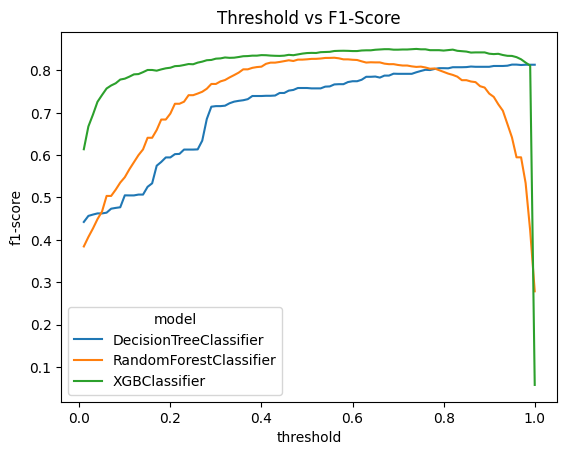

In [137]:
# plot threshold vs f1-score
df_thresh_perf = pd.concat(
    [pd.DataFrame(dt_thresh_perf), 
     pd.DataFrame(rf_thresh_perf), 
     pd.DataFrame(xgb_thresh_perf)])

sns.lineplot(data=df_thresh_perf, x='threshold', y='f1-score', hue='model')
plt.title('Threshold vs F1-Score')
plt.show()

In [158]:
# function to get the best model threshold
def choose_best_threshold(thresh_result: List, path: Path) -> Dict:
    
    """
    Select the best threshold and model based on the highest metric score.

    Parameters
    ----------
    thresh_result : List[Dict[str, Any]]
        List of threshold tuning results from multiple models.
        Each element contains threshold values and metric scores.

    path : Path
        File path to save the best threshold information in JSON format.

    Returns
    -------
    Dict[str, Any]
        Dictionary containing the best model name, threshold, and metric score.
    """

    # combine three threshold results into one dataframe
    df_thresh_result = pd.DataFrame()
    for result in thresh_result:
        df_thresh_result = pd.concat([pd.DataFrame(df_thresh_result), pd.DataFrame(result)])
    
    # choose the first index by the biggest f1-score
    df_thresh_sorted = df_thresh_result.sort_values(by='f1-score', ascending=False).reset_index(drop=True)
    threshold_chosen = df_thresh_sorted.iloc[0].to_dict()

    # save the best threshold to json
    with open(path, 'w') as file:
        json.dump(threshold_chosen, file, indent=4)

    return threshold_chosen

In [159]:
best_threshold = choose_best_threshold(
    thresh_result=[dt_thresh_perf, rf_thresh_perf, xgb_thresh_perf],
    path=project_root/'models'/'best_threshold.json'
)

# **Predict & Evaluate Test Data**

In [ ]:
def evaluate_test(estimator: Any, threshold: float, X_test: pd.DataFrame, y_test: pd.Series) -> Any:
    """
    Evaluate a trained classification model on the test dataset
    using a selected probability threshold.

    Parameters
    ----------
    estimator : Any
        A trained classification model that supports `predict_proba()`,
        such as DecisionTreeClassifier, RandomForestClassifier, or XGBoost.

    threshold : float
        The probability cutoff used to convert predicted probabilities
        into class labels. Values >= threshold are classified as positive (1),
        otherwise negative (0).

    X_test : pd.DataFrame
        Test feature dataset used for evaluation.

    y_test : pd.Series
        True target labels corresponding to the test dataset.

    Returns
    -------
    str
        A text classification report containing precision, recall,
        f1-score, and support for each class.
    """
    y_pred_test = (estimator.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    return classification_report(y_test, y_pred_test)

In [20]:
def read_json_file(path):
    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

threshold_json = read_json_file(path=project_root/'models'/'best_threshold.json')
threshold_json

{'model': 'XGBClassifier',
 'threshold': 0.74,
 'recall': 0.7580872011251758,
 'precision': 0.9694244604316546,
 'f1-score': 0.850828729281768}

In [22]:
best_model = deserialize_data(path=project_root/'models'/'xgb_model.pkl')

test_performance = evaluate_test(
    estimator=best_model,
    threshold=threshold_json['threshold'],
    X_test=X_test,
    y_test=y_test
)
print('')
print(test_performance)

Load object. . .
/home/bagaskoroah/ml_process/BAGAS_MLPROCESS/models/xgb_model.pkl has been successfully loaded!.

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2548
           1       0.97      0.73      0.83       711

    accuracy                           0.94      3259
   macro avg       0.95      0.86      0.90      3259
weighted avg       0.94      0.94      0.93      3259

